In [ ]:
asdasdasdasdasdasdasdasdasd

In [3]:
import os
import sys
# Here you need to have same Python version on your local machine adn on worker node i.e. EC2. here both should have python3.
os.environ["PYSPARK_PYTHON"] = "/bin/python3"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

In [4]:
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Credit Card Application Approval Model').config('spark.ui.showConsoleProgress', 'false').getOrCreate()

22/10/19 16:32:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
from pyspark import SparkFiles
spark.sparkContext.addFile("https://s3.amazonaws.com/sqoop.oozie.ml/credit_record.csv")
credit_record_df = spark.read.csv(SparkFiles.get("credit_record.csv"),inferSchema=True,header=True)
credit_record_df.show(5)

+-------+--------------+------+
|     ID|MONTHS_BALANCE|STATUS|
+-------+--------------+------+
|5001711|             0|     X|
|5001711|            -1|     0|
|5001711|            -2|     0|
|5001711|            -3|     0|
|5001712|             0|     C|
+-------+--------------+------+
only showing top 5 rows



In [7]:
print(credit_record_df.count(), len(credit_record_df.columns))

1048575 3


In [8]:
spark.sparkContext.addFile("https://s3.amazonaws.com/sqoop.oozie.ml/application_record.csv")
application_df = spark.read.csv(SparkFiles.get("application_record.csv"),inferSchema=True,header=True)
application_df.show(5) 

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|5008804|          M|           Y|              Y|           0|        427500.0|             Working|    Higher education|      Civil marriage| Rented apartment|    -12005|        -4542|         1

In [9]:
#Different categories of Status which are there in credit_record_df.
credit_record_df.groupBy('STATUS').count().show()

+------+------+
|STATUS| count|
+------+------+
|     3|   320|
|     0|383120|
|     5|  1693|
|     C|442031|
|     X|209230|
|     1| 11090|
|     4|   223|
|     2|   868|
+------+------+



In [10]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
def transform_status(input_str):
    if input_str in ("X","0","1","C"):
        return 0
    else:
        return 1

In [11]:
transform_status_udf = F.udf(f=lambda row: transform_status(row),returnType = T.IntegerType())

In [12]:
updated_df = credit_record_df.withColumn("TARGET",transform_status_udf(F.col("STATUS")))
updated_df.show(5)

+-------+--------------+------+------+
|     ID|MONTHS_BALANCE|STATUS|TARGET|
+-------+--------------+------+------+
|5001711|             0|     X|     0|
|5001711|            -1|     0|     0|
|5001711|            -2|     0|     0|
|5001711|            -3|     0|     0|
|5001712|             0|     C|     0|
+-------+--------------+------+------+
only showing top 5 rows



Traceback (most recent call last):
  File "/home/ec2-user/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 170, in manager
  File "/home/ec2-user/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 73, in worker
  File "/home/ec2-user/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 402, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/ec2-user/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 717, in read_int
    raise EOFError
EOFError


In [13]:
updated_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- TARGET: integer (nullable = true)



In [14]:
updated_df.groupBy('TARGET').count().show()

+------+-------+
|TARGET|  count|
+------+-------+
|     1|   3104|
|     0|1045471|
+------+-------+



In [15]:
new_df = updated_df.join(updated_df.groupBy('ID').agg(F.max('TARGET').alias('Target_final')).select('ID','Target_final'),'ID')

In [16]:
new_df.show()

+-------+--------------+------+------+------------+
|     ID|MONTHS_BALANCE|STATUS|TARGET|Target_final|
+-------+--------------+------+------+------------+
|5001711|             0|     X|     0|           0|
|5001711|            -1|     0|     0|           0|
|5001711|            -2|     0|     0|           0|
|5001711|            -3|     0|     0|           0|
|5001712|             0|     C|     0|           0|
|5001712|            -1|     C|     0|           0|
|5001712|            -2|     C|     0|           0|
|5001712|            -3|     C|     0|           0|
|5001712|            -4|     C|     0|           0|
|5001712|            -5|     C|     0|           0|
|5001712|            -6|     C|     0|           0|
|5001712|            -7|     C|     0|           0|
|5001712|            -8|     C|     0|           0|
|5001712|            -9|     0|     0|           0|
|5001712|           -10|     0|     0|           0|
|5001712|           -11|     0|     0|           0|
|5001712|   

Traceback (most recent call last):
  File "/home/ec2-user/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 170, in manager
  File "/home/ec2-user/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 73, in worker
  File "/home/ec2-user/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 402, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/ec2-user/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 717, in read_int
    raise EOFError
EOFError


In [17]:
df = new_df.select('ID','Target_final').distinct()

In [18]:
df.show()

+-------+------------+
|     ID|Target_final|
+-------+------------+
|5060127|           0|
|5095205|           0|
|5114046|           0|
|5121952|           0|
|5120456|           0|
|5105081|           0|
|5114083|           0|
|5121158|           0|
|5104882|           0|
|5137314|           0|
|5009694|           0|
|5058371|           0|
|5024388|           0|
|5022103|           0|
|5135959|           0|
|5139314|           0|
|5022751|           0|
|5089303|           0|
|5118528|           0|
|5003274|           0|
+-------+------------+
only showing top 20 rows



In [19]:
df.select('Target_final').distinct().show()

+------------+
|Target_final|
+------------+
|           1|
|           0|
+------------+



In [20]:
df.count()

45985

In [21]:
application_df.count()

438557

In [22]:
#Merge with the application_df using inner join on column 'ID'
merged = application_df.join(df,on='ID',how='inner')
merged.show(20)

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+--------------------+---------------+------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|     OCCUPATION_TYPE|CNT_FAM_MEMBERS|Target_final|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+--------------------+---------------+------------+
|5009033|          F|           N|              N|           0|        255150.0|           Pensioner|   Incomplete higher|      Civil marriage

In [23]:
merged.count()

36457

In [24]:
merged.groupBy('Target_final').count().show()

+------------+-----+
|Target_final|count|
+------------+-----+
|           1|  616|
|           0|35841|
+------------+-----+



# Exploratory Data Analysis using Seaborn and Matplotlib

***Install Seaborn***

In [25]:
import pip
pip.main(['install','seaborn'])

Defaulting to user installation because normal site-packages is not writeable


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

***Import Matplotlib.pyplot and seaborn***

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

***Converting Spark DF to Pandas dataframe for visualizations and exploratory data analysis***

In [27]:
pandas_df = merged.toPandas()
pandas_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Target_final
0,5009033,F,N,N,0,255150.0,Pensioner,Incomplete higher,Civil marriage,Rented apartment,-18682,365243,1,0,0,0,None,2.0,0
1,5009304,F,N,N,0,112500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-22061,365243,1,0,0,0,None,1.0,0
2,5009355,F,N,N,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19692,-5273,1,1,1,0,Laborers,2.0,0
3,5009429,M,N,N,0,198000.0,Working,Secondary / secondary special,Single / not married,With parents,-8657,-1164,1,1,0,0,Laborers,1.0,0
4,5010070,F,N,Y,0,279000.0,State servant,Higher education,Single / not married,House / apartment,-11091,-617,1,0,0,1,Managers,1.0,0


In [28]:
#Shape of our pandas dataframe
pandas_df.shape

(36457, 19)

## Checking Missing Values in our dataset

In [29]:
# Info for all columns
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int32  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int32  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int32  
 11  DAYS_EMPLOYED        36457 non-null  int32  
 12  FLAG_MOBIL           36457 non-null  int32  
 13  FLAG_WORK_PHONE      36457 non-null  int32  
 14  FLAG_PHONE           36457 non-null  int32  
 15  FLAG_EMAIL           36457 non-null 

In [30]:
pandas_df.isnull().sum()

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
Target_final               0
dtype: int64

> ***Observations:*** <br>
> Feature OCCUPATION_TYPE has 11323 missing values. Since it's a huge missing data, we will not drop these rows, instead we can do some imputation on this column. Or we can also make 'Missing Occupation' as a category and categorize all the missing values. 

In [31]:
# Checking dtypes
pandas_df.dtypes

ID                       int32
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int32
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int32
DAYS_EMPLOYED            int32
FLAG_MOBIL               int32
FLAG_WORK_PHONE          int32
FLAG_PHONE               int32
FLAG_EMAIL               int32
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
Target_final             int32
dtype: object

In [ ]:
#Function to help in EDA
#For understanding the data more clearly, and analyzing columns on the basis of TARGET variable,
#We can create a function to provide us the defaulter percentage for each of the category.
def calculate_delinquent_pct(df,col):
    temp_df = pd.DataFrame(columns=['Category','Delinquent Percentage'])
    for cat in df[col].unique():
        defaulter_count = df[(df[col]==cat) & (df['TARGET']==1)].shape[0]
        total_count = df[df[col]==cat].shape[0]
        temp_df = temp_df.append({'Category':cat,'Delinquent Percentage':(defaulter_count/total_count * 100)},ignore_index=True)
    return temp_df.sort_values(by='Delinquent Percentage',ascending=False)

## Numerical Features EDA

In [32]:
pandas_df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,Target_final
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,0.016897
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,0.128886
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,0.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,1.000000


***Observations based on Describe() method used above:***

In [33]:
# FEATURE: CNT_CHILDREN
# We see max CNT_CHILDREN to be 19, which seems highly unlikely.
# Let's explore the data
pandas_df.CNT_CHILDREN.value_counts()

0     25201
1      7492
2      3256
3       419
4        63
5        20
14        3
7         2
19        1
Name: CNT_CHILDREN, dtype: int64

In [ ]:
calculate_delinquent_pct(pandas_df,'CNT_CHILDREN')

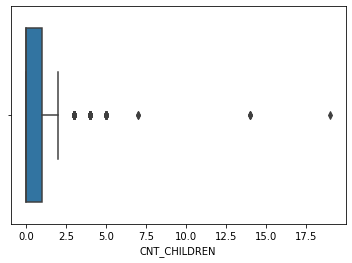

In [34]:
sns.boxplot(data=pandas_df,x='CNT_CHILDREN')
plt.show()

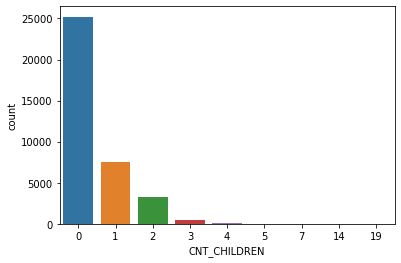

In [35]:
# There are 3 customerID with 14 number of childrens and 1 customer with 19 children which seems highly unlikely. 
# So it's an outlier.
sns.countplot(data=pandas_df,x='CNT_CHILDREN')
plt.show()

> ***Observations:*** <br>
> Feature CNT_CHILDREN has some outliers 14 and 19, which seems highly unlikely. So we will replace these values later in Feature engineering part.

In [36]:
# FEATURE: DAYS_BIRTH
# Days birth is birthdate which is in negative, i.e. -1 means birthday was yesterday, so we need to convert these values to
# age while feature engineering.

In [37]:
# No value should be greater than 0
pandas_df[pandas_df.DAYS_BIRTH > 0]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Target_final


> ***Observations:*** <br>
> Feature DAYS_BIRTH is in negative values and we need to transform this feature into Age by dividing this by 365. Then we can bin the age column to find a range and get hidden insights.

In [38]:
# FEATURE: DAYS_EMPLOYED
# Days employed should not be positive
temp = pandas_df[pandas_df.DAYS_EMPLOYED > 0]
temp.shape

(6135, 19)

In [39]:
# But we see there are 6135 values whose DAYS_EMPLOYED > 0
# Let's check the INCOME TYPE of these people.
temp['NAME_INCOME_TYPE'].value_counts()

Pensioner    6135
Name: NAME_INCOME_TYPE, dtype: int64

> ***Observations:*** <br>
> Feature DAYS_EMPLOYED has both positive and negative values. Positive values are only for People with INCOME_TYPE = Pensioner. This is because Pensioners are not employed. We need to do some feature transformation for positive values.

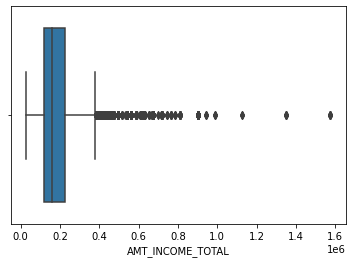

In [40]:
# FEATURE: AMT_INCOME_TOTAL
sns.boxplot(data=pandas_df,x='AMT_INCOME_TOTAL')
plt.show()

In [41]:
# FEATURE: FLAG_MOBIL
pandas_df.FLAG_MOBIL.value_counts()

1    36457
Name: FLAG_MOBIL, dtype: int64

> ***Observations:*** <br>
> All are FLAG_MOBIL 1 , so this column is of no use to us. And we will delete this column later on.

In [42]:
# FEATURE: FLAG_WORK_PHONE
pandas_df.FLAG_WORK_PHONE.value_counts(normalize=True)

0    0.774474
1    0.225526
Name: FLAG_WORK_PHONE, dtype: float64

In [ ]:
calculate_delinquent_pct(pandas_df,'FLAG_WORK_PHONE')

> ***Observations:*** <br>
> Imbalanced data that many people have not provided their work phone number in the applications.

In [43]:
# FEATURE: FLAG_PHONE
pandas_df.FLAG_PHONE.value_counts(normalize=True)

0    0.705187
1    0.294813
Name: FLAG_PHONE, dtype: float64

In [ ]:
calculate_delinquent_pct(pandas_df,'FLAG_PHONE')

> ***Observations:*** <br>
> Imbalanced data that many people have not provided their personal phone number in the applications.

In [44]:
# FEATURE: FLAG_EMAIL
pandas_df.FLAG_EMAIL.value_counts(normalize=True)
# It's a categorical column

0    0.910278
1    0.089722
Name: FLAG_EMAIL, dtype: float64

In [ ]:
calculate_delinquent_pct(pandas_df,'FLAG_EMAIL')

> ***Observations:*** <br>
> Feature FLAG_EMAIL though being integer, is a categorical column, 1 meaning Email is provided and 0 meaning Email is NOT provided.

In [45]:
# FEATURE: CNT_FAM_MEMBERS
pandas_df.CNT_FAM_MEMBERS.value_counts()

2.0     19463
1.0      6987
3.0      6421
4.0      3106
5.0       397
6.0        58
7.0        19
15.0        3
9.0         2
20.0        1
Name: CNT_FAM_MEMBERS, dtype: int64

In [ ]:
calculate_delinquent_pct(pandas_df,'CNT_FAM_MEMBERS')

> ***Observations:*** <br>
> Same as number of childrens, either we update both of them or remove them. Upto us.

# CATEGORICAL VALUES

In [46]:
cat_cols = pandas_df.select_dtypes(include='object').columns
pandas_df[cat_cols].head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE
0,F,N,N,Pensioner,Incomplete higher,Civil marriage,Rented apartment,None
1,F,N,N,Pensioner,Secondary / secondary special,Widow,House / apartment,None
2,F,N,N,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers
3,M,N,N,Working,Secondary / secondary special,Single / not married,With parents,Laborers
4,F,N,Y,State servant,Higher education,Single / not married,House / apartment,Managers


In [47]:
# FEATURE: CODE_GENDER
pandas_df.CODE_GENDER.value_counts(normalize=True)

F    0.670105
M    0.329895
Name: CODE_GENDER, dtype: float64

In [48]:
pandas_df.shape

(36457, 19)

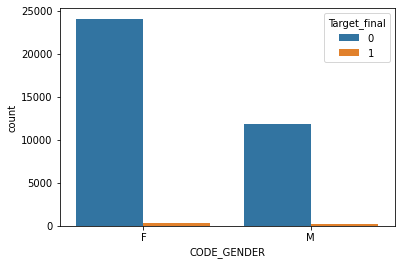

In [49]:
sns.countplot(data=pandas_df,x='CODE_GENDER',hue='Target_final')
plt.show()

In [ ]:
calculate_delinquent_pct(pandas_df,'CODE_GENDER')

In [50]:
# FEATURE: FLAG OWN CAR
pandas_df.FLAG_OWN_CAR.value_counts(normalize=True)

N    0.620292
Y    0.379708
Name: FLAG_OWN_CAR, dtype: float64

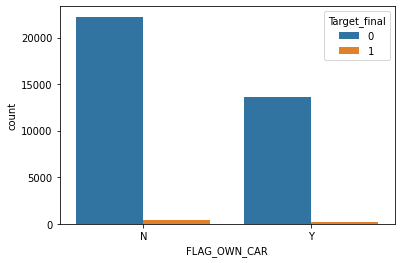

In [51]:
sns.countplot(data=pandas_df,x='FLAG_OWN_CAR',hue='Target_final')
plt.show()

In [ ]:
calculate_delinquent_pct(pandas_df,'FLAG_OWN_CAR')

In [52]:
# FEATURE: FLAG_OWN_REALTY
pandas_df.FLAG_OWN_REALTY.value_counts(normalize=True)

Y    0.672189
N    0.327811
Name: FLAG_OWN_REALTY, dtype: float64

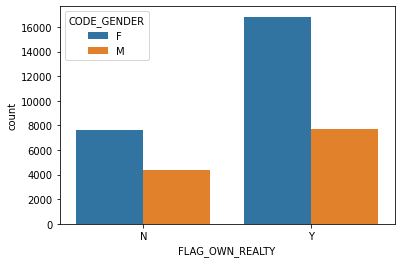

In [53]:
sns.countplot(data=pandas_df,x='FLAG_OWN_REALTY',hue='CODE_GENDER')
plt.show()

In [ ]:
calculate_delinquent_pct(pandas_df,'FLAG_OWN_REALTY')

In [54]:
# FEATURE: INCOME TYPE
pandas_df.NAME_INCOME_TYPE.value_counts(normalize=True)

Working                 0.516197
Commercial associate    0.232877
Pensioner               0.168747
State servant           0.081877
Student                 0.000302
Name: NAME_INCOME_TYPE, dtype: float64

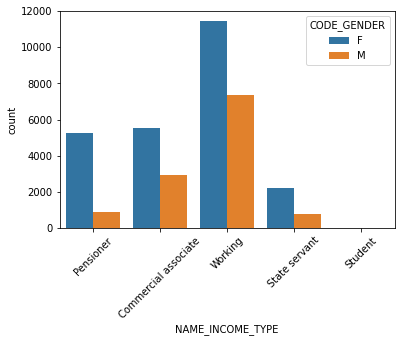

In [55]:
sns.countplot(data=pandas_df,x='NAME_INCOME_TYPE',hue='CODE_GENDER')
plt.xticks(rotation=45)
plt.show()

In [ ]:
calculate_delinquent_pct(pandas_df,'NAME_INCOME_TYPE')

In [56]:
# Education type
pandas_df.NAME_EDUCATION_TYPE.value_counts()

Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: NAME_EDUCATION_TYPE, dtype: int64

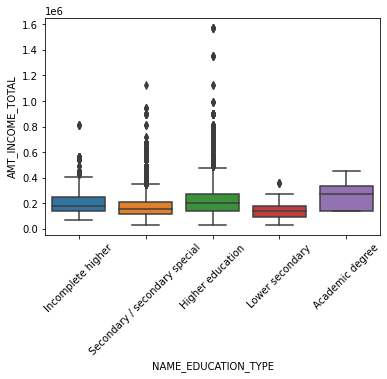

In [57]:
sns.boxplot(data=pandas_df,x='NAME_EDUCATION_TYPE',y='AMT_INCOME_TOTAL')
plt.xticks(rotation=45)
plt.show()

In [ ]:
calculate_delinquent_pct(pandas_df,'NAME_EDUCATION_TYPE')

In [58]:
# Applicants with completed Secondary or Higher Education are much more likely to have a higher annual income than others.

In [59]:
pandas_df.NAME_FAMILY_STATUS.value_counts(normalize=True)

Married                 0.687056
Single / not married    0.132457
Civil marriage          0.080780
Separated               0.057684
Widow                   0.042022
Name: NAME_FAMILY_STATUS, dtype: float64

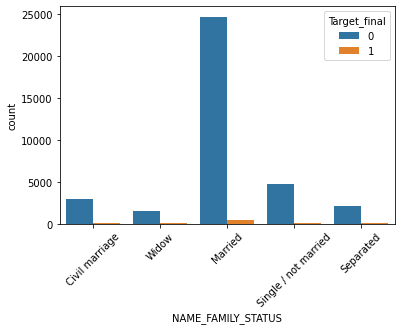

In [60]:
sns.countplot(data=pandas_df,x='NAME_FAMILY_STATUS',hue='Target_final')
plt.xticks(rotation=45)
plt.show()

In [ ]:
calculate_delinquent_pct(pandas_df,'NAME_FAMILY_STATUS')

In [61]:
# AMT_INCOME_TOTAL
merged.agg({'AMT_INCOME_TOTAL':'avg'}).show()

+---------------------+
|avg(AMT_INCOME_TOTAL)|
+---------------------+
|   186685.73666236937|
+---------------------+



In [62]:
pandas_df.AMT_INCOME_TOTAL.describe()

count    3.645700e+04
mean     1.866857e+05
std      1.017892e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: AMT_INCOME_TOTAL, dtype: float64

In [63]:
# NAME HOUSING TYPE
pandas_df.NAME_HOUSING_TYPE.value_counts()

House / apartment      32548
With parents            1776
Municipal apartment     1128
Rented apartment         575
Office apartment         262
Co-op apartment          168
Name: NAME_HOUSING_TYPE, dtype: int64

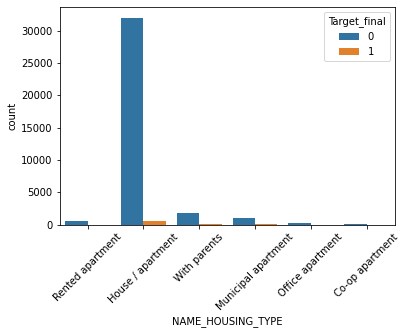

In [64]:
sns.countplot(data=pandas_df,x='NAME_HOUSING_TYPE',hue='Target_final')
plt.xticks(rotation=45)
plt.show()

In [65]:
# NAME FAMILY STATUS
pandas_df.NAME_FAMILY_STATUS.value_counts()

Married                 25048
Single / not married     4829
Civil marriage           2945
Separated                2103
Widow                    1532
Name: NAME_FAMILY_STATUS, dtype: int64

In [66]:
# NAME HOUSING TYPE
pandas_df.NAME_HOUSING_TYPE.value_counts()

House / apartment      32548
With parents            1776
Municipal apartment     1128
Rented apartment         575
Office apartment         262
Co-op apartment          168
Name: NAME_HOUSING_TYPE, dtype: int64

In [67]:
# OCCUPATION TYPE
pandas_df.OCCUPATION_TYPE.value_counts()

Laborers                 6211
Core staff               3591
Sales staff              3485
Managers                 3012
Drivers                  2138
High skill tech staff    1383
Accountants              1241
Medicine staff           1207
Cooking staff             655
Security staff            592
Cleaning staff            551
Private service staff     344
Low-skill Laborers        175
Waiters/barmen staff      174
Secretaries               151
HR staff                   85
Realty agents              79
IT staff                   60
Name: OCCUPATION_TYPE, dtype: int64

In [ ]:
calculate_delinquent_pct(pandas_df,'OCCUPATION_TYPE')

In [68]:
pandas_df.OCCUPATION_TYPE.isnull().sum()

11323

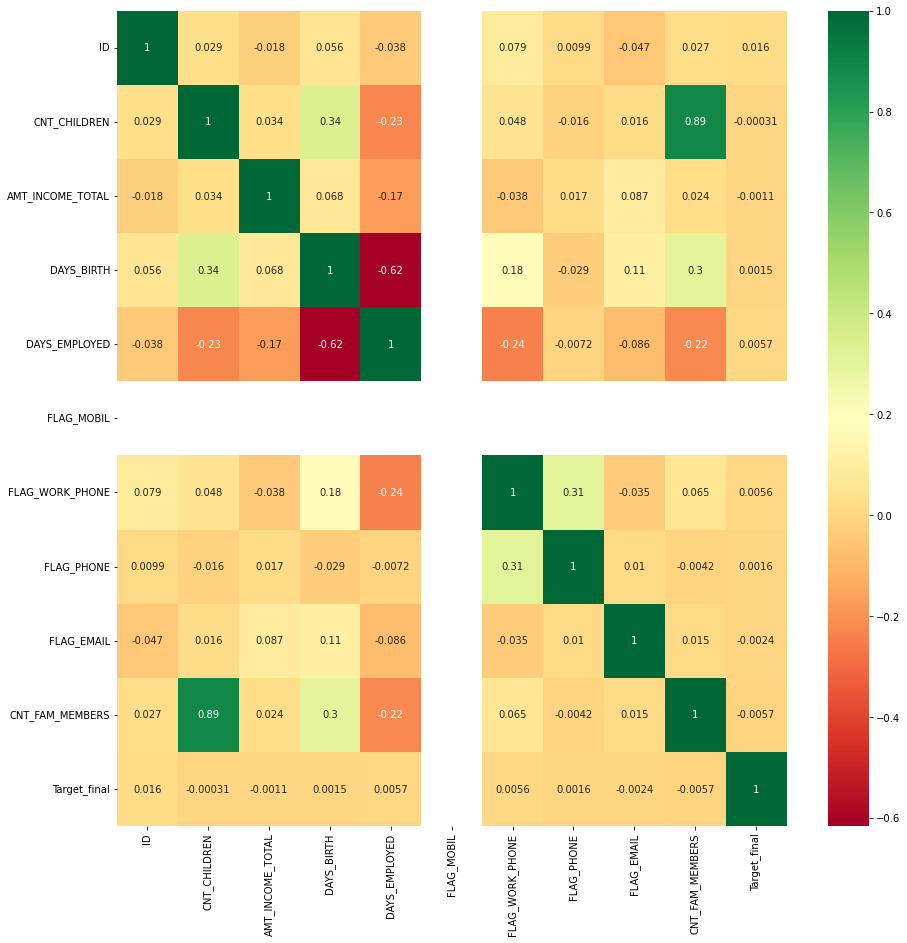

In [69]:
plt.figure(figsize=(15,15))
sns.heatmap(pandas_df.corr(),annot=True,cmap='RdYlGn')
plt.show()

In [70]:
# We need to clean this column FLAG_MOBIL as all the values are the same as 1.

***Some Observations:***
1. OCCUPATION TYPE Missing values - do some missing value treatment
2. We see max CNT_CHILDREN to be 19, which seems highly unlikely.
3. Days birth is birthdate which is in negative, i.e. -1 means birthday was yesterday, so we need to convert these values.
4. FLAG_MOBIL only has 1 value, so the column is not useful to us, so we will drop that column.
5. Days employed has both positive and negative values, and this is fine because only applicants with INCOME_TYPE = 'Pensioner',
    are having positive days employed values while all other are getting negative values. This might be because Pensioners
    salary data might be calculated from the day they will receive pension.
6. Around 77% of the applicants have no submitted their work phone number, which makes the column highly imbalanced.
7. Almost 30% of the applicants have not even submitted their personal phone number.
8. FLAG_EMAIL column
    a. Type is integer BUT IT IS A CATEGORICAL COLUMN.
    b. So we need to treat it as a CATEGORICAL COLUMN (1 means Email provided otherwise 0)
9. CNT_FAM_MEMBERS similar to CNT_CHILDREN, also has 4 outliers which we need to treat.

CATEGORICAL COLUMNS
10. 67% of the applicants are Females.
11. 62% of the applicants does not have car.
12. 67% of the applicants own realty.
13. Above 50% of the applicants are from working class.
14. Approx 69% of the applicants are Married.

***Questions according to Assignment:***
1. What is the proportion of females in the applicant customer base? <br>
*Answer:* 67% <br>
<br>
2. Is homeownership higher among male applicants or female applicants? <br>
*Answer:* Females <br>
<br>
3. Is there any correlation between the customer's income level and education level?
*Answer:* Yes there is a correlation between the two. <br>
<br>
4. What is the average and median salary of the applicant base? <br>
*Answer:* Average:186685.73666236937 , Median: 157500.0 <br>
<br>    
5. Is the proportion of bad customers higher for people who own cars? <br>
*Answer:* No. <br>
<br>
6. Is the proportion of bad customers higher for those living on rent than the rest of the population? <br>
*Answer:* Yes<br>
<br>
7. Is the proportion of bad customers higher for those who are single than married customers? <br>
*Answer:* No <br>
<br>

# Feature Engineering

In [73]:
# OCCUPATION COLUMN
merged.groupBy('OCCUPATION_TYPE').count().show()

+--------------------+-----+
|     OCCUPATION_TYPE|count|
+--------------------+-----+
|                null|11323|
|            Managers| 3012|
|            HR staff|   85|
|      Medicine staff| 1207|
|         Accountants| 1241|
|            Laborers| 6211|
|      Cleaning staff|  551|
|Private service s...|  344|
|             Drivers| 2138|
|         Sales staff| 3485|
|       Realty agents|   79|
|            IT staff|   60|
|      Security staff|  592|
|         Secretaries|  151|
|  Low-skill Laborers|  175|
|          Core staff| 3591|
|       Cooking staff|  655|
|High skill tech s...| 1383|
|Waiters/barmen staff|  174|
+--------------------+-----+



***Making a new column 'OCCUPATION_TYPE_FE' which will replace the missing values with the value 'Laborers' because it's count is highest among all the other categories.***

In [74]:
merged = merged.withColumn("OCCUPATION_TYPE_FE",F.when(merged.OCCUPATION_TYPE.isNull(),"Laborers").otherwise(merged.OCCUPATION_TYPE))

In [75]:
merged.groupBy('OCCUPATION_TYPE_FE').count().show()

+--------------------+-----+
|  OCCUPATION_TYPE_FE|count|
+--------------------+-----+
|            Managers| 3012|
|            HR staff|   85|
|      Medicine staff| 1207|
|         Accountants| 1241|
|            Laborers|17534|
|      Cleaning staff|  551|
|Private service s...|  344|
|             Drivers| 2138|
|         Sales staff| 3485|
|       Realty agents|   79|
|            IT staff|   60|
|      Security staff|  592|
|         Secretaries|  151|
|  Low-skill Laborers|  175|
|          Core staff| 3591|
|       Cooking staff|  655|
|High skill tech s...| 1383|
|Waiters/barmen staff|  174|
+--------------------+-----+



In [76]:
# OUTLIER TREATMENT FOR CNT_CHILDREN
merged.groupBy('CNT_CHILDREN').count().show()

+------------+-----+
|CNT_CHILDREN|count|
+------------+-----+
|           1| 7492|
|           3|  419|
|           5|   20|
|          19|    1|
|           4|   63|
|           7|    2|
|          14|    3|
|           2| 3256|
|           0|25201|
+------------+-----+



***Making a new column 'CNT_CHILDREN_FE' in which if the count is greater than 7, it replaces it by 0, thinking it's a mistake by the applicant, and there is no way of having more than 7 children. And also since mode=0, so 0 is preferred for outlier treatment.***

In [77]:
merged = merged.withColumn("CNT_CHILDREN_FE",F.when(merged.CNT_CHILDREN >7,0).otherwise(merged.CNT_CHILDREN))
merged.groupBy('CNT_CHILDREN_FE').count().show()

+---------------+-----+
|CNT_CHILDREN_FE|count|
+---------------+-----+
|              1| 7492|
|              3|  419|
|              5|   20|
|              4|   63|
|              7|    2|
|              2| 3256|
|              0|25205|
+---------------+-----+



In [78]:
# CNT_FAM_MEMBERS Outlier treatment

In [79]:
merged.groupBy('CNT_FAM_MEMBERS').count().show()

+---------------+-----+
|CNT_FAM_MEMBERS|count|
+---------------+-----+
|            7.0|   19|
|            1.0| 6987|
|            4.0| 3106|
|            3.0| 6421|
|            2.0|19463|
|            6.0|   58|
|           20.0|    1|
|            5.0|  397|
|           15.0|    3|
|            9.0|    2|
+---------------+-----+



***Doing feature engineering and making new feature CNT_FAM_MEMBERS_FE such that any count greater than 10 would be assumed as an outlier and the family would be considered to have 2 family members instead. Also mode = 2 , so 2 is prefferred for outlier treatment here.***

In [80]:
merged = merged.withColumn("CNT_FAM_MEMBERS_FE",F.when(merged.CNT_FAM_MEMBERS > 10,2).otherwise(merged.CNT_FAM_MEMBERS))
merged.groupBy('CNT_FAM_MEMBERS_FE').count().show()

+------------------+-----+
|CNT_FAM_MEMBERS_FE|count|
+------------------+-----+
|               7.0|   19|
|               1.0| 6987|
|               4.0| 3106|
|               3.0| 6421|
|               2.0|19467|
|               6.0|   58|
|               5.0|  397|
|               9.0|    2|
+------------------+-----+



In [81]:
# FLAG_MOBIL
merged.groupBy('FLAG_MOBIL').count().show()

+----------+-----+
|FLAG_MOBIL|count|
+----------+-----+
|         1|36457|
+----------+-----+



***Dropping column FLAG_MOBIL as it has only 1 value throughout the whole dataset and doesn't contribute to the model learning/training.***

In [82]:
# Drop this value, since it is of no use.
merged = merged.drop('FLAG_MOBIL')

In [83]:
merged.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- Target_final: integer (nullable = true)
 |-- OCCUPATION_TYPE_FE: string (nullable = true)
 |-- CNT_CHILDREN_FE: integer (nullable = true)
 |-- CNT_FAM_MEMBERS_FE: double (nullable = true)



In [84]:
# DAYS_BIRTH
merged.groupBy('DAYS_BIRTH').count().show()

+----------+-----+
|DAYS_BIRTH|count|
+----------+-----+
|     -9866|    5|
|    -10659|    4|
|    -20295|    9|
|    -18186|    5|
|    -11206|   17|
|    -19648|    2|
|    -22936|    6|
|    -10396|   11|
|    -19580|    2|
|    -23679|    6|
|    -12070|    5|
|    -17570|    5|
|    -19210|    9|
|    -14614|    5|
|     -9762|    5|
|     -8946|    2|
|    -23077|    3|
|     -9704|    2|
|     -8145|    1|
|    -17743|    5|
+----------+-----+
only showing top 20 rows



***Defining a function to convert DAYS_BIRTH feature into Age.***
1. Create function
2. Make a udf function
3. Use the udf on the pyspark dataframe to get a new column/feature as 'Age_FE'

In [85]:
def convert_to_Age(days_birth):
    age = abs(days_birth)//365
    return age

transform_days_birth_to_age_udf = F.udf(f=lambda row: convert_to_Age(row),returnType=T.IntegerType())

In [86]:
merged = merged.withColumn("Age_FE",transform_days_birth_to_age_udf(F.col('DAYS_BIRTH')))
merged.select('Age_FE').show()

+------+
|Age_FE|
+------+
|    50|
|    40|
|    48|
|    44|
|    56|
|    25|
|    35|
|    47|
|    36|
|    48|
|    31|
|    27|
|    29|
|    50|
|    60|
|    61|
|    33|
|    53|
|    46|
|    52|
+------+
only showing top 20 rows



In [87]:
merged.groupBy('AGE_FE').max('AGE_FE').show()

+------+-----------+
|AGE_FE|max(AGE_FE)|
+------+-----------+
|    31|         31|
|    65|         65|
|    53|         53|
|    34|         34|
|    28|         28|
|    27|         27|
|    26|         26|
|    44|         44|
|    22|         22|
|    47|         47|
|    52|         52|
|    40|         40|
|    20|         20|
|    57|         57|
|    54|         54|
|    48|         48|
|    64|         64|
|    41|         41|
|    43|         43|
|    37|         37|
+------+-----------+
only showing top 20 rows



***Defining a function find_median to get the median of column DAYS_EMPLOYED and substitute it to rows where DAYS_EMPLOYED is positive. As we saw earlier, applicants with INCOME_TYPE as Pensioners have DAYS_EMPLOYED in positive which will act as an Outlier. That's why we are replacing it with the median value.***

In [88]:
import numpy as np
def find_median(values_list):
    try:
        median = np.median(values_list)
        return round(float(median),2)
    except Exception:
        return None

In [89]:
print(find_median(merged.select('DAYS_EMPLOYED').toPandas().values.tolist()))

-1552.0


In [90]:
merged = merged.withColumn('DAYS_EMPLOYED_FE',F.when(merged.DAYS_EMPLOYED > 0,-1552.0).otherwise(merged.DAYS_EMPLOYED))

In [91]:
merged.agg({'DAYS_EMPLOYED_FE': 'max' }).show()

+---------------------+
|max(DAYS_EMPLOYED_FE)|
+---------------------+
|                -17.0|
+---------------------+



# WOE and IV

***Using WOE to find WOE_transformation columns on categorical columns and then using IV value to eliminate week predictors.***

In [92]:
from pyspark.sql import DataFrame
class WOE_IV(object):
    
    """
    This class contains methods that are used for calculating the WOE and IV values in a given dataset.
    
    Attributes
    ----------
    df : spark DataFrame
        The spark dataframe
    cols_to_woe : list
        Columns that you want to convert in WOE and IV
    label_column : str
        target column of the data
    good_label : str
        Predicted variable in the form of 1 or 0
    """
    
    def __init__(self, df: DataFrame, cols_to_woe: [str], label_column: str, good_label: str):
        self.df = df
        self.cols_to_woe = cols_to_woe
        self.label_column = label_column
        self.good_label = good_label
        self.fit_data = {} # This is a dictionary which will store all the WOE and IV computed in the latter part of the code

    def fit(self):  
        """
        This method takes the columns in 'cols_to_woe' and calculates the good and bad amounts, and then assigns the WOE values in the dictionary, 'fit_data'
        """
        for col_to_woe in self.cols_to_woe: # Iterating over each column in the list, cols_to_woe
            
            total_good = self.compute_total_amount_of_good() # Computes the total amount of good labels in the entire dataset
            total_bad = self.compute_total_amount_of_bad() # Computes the total amount of bad labels in the entire dataset
            
            woe_df = self.df.select(col_to_woe) # This dataframe stores the column, col_to_woe from the DataFrame
            categories = woe_df.distinct().collect() # Creates a list of all the distinct categories in the column, col_to_woe
            for category_row in categories: # Iterating over each category in the distinct categories of the column
                category = category_row[col_to_woe]
                
                # For each category, we calculate the good_amount and bad_amount
                good_amount = self.compute_good_amount(col_to_woe, category)
                bad_amount = self.compute_bad_amount(col_to_woe, category)
                
                # If the good_amount or bad_amount is 0, we replace it with 0.5, because in the calculation of woe, it comes in the denominator resulting in a Nan value which will give an error
                good_amount = good_amount if good_amount != 0 else 0.5
                bad_amount = bad_amount if bad_amount != 0 else 0.5

                # Calculating the fraction of good_amount and bad_amount specific to that category
                good_dist = good_amount / total_good
                bad_dist = bad_amount / total_bad

                # Calling the build_fit_data method which calculates the WOE and IV for the category in the column and stores it in the dictionary, fit_data
                self.build_fit_data(col_to_woe, category, good_dist, bad_dist)

    def transform(self, df: DataFrame):
        """
        This method creates a column called "col_to_woe + '_woe'" which replaces the given category value with the WOE value.
        It finally returns a final dataframe containing the WOE values in place of the columns
        """
        def _encode_woe(col_to_woe_):
            return F.coalesce(
                *[F.when(F.col(col_to_woe_) == category, F.lit(woe_iv['woe']))
                  for category, woe_iv in self.fit_data[col_to_woe_].items()]
            )

        for col_to_woe, woe_info in self.fit_data.items():
            # Adds another column to the df containing the final WOE values
            df = df.withColumn(col_to_woe + '_woe', _encode_woe(col_to_woe))
        return df

    def compute_total_amount_of_good(self):
     # Computes the total amount of good labels in the entire dataset
        return self.df.select(self.label_column).filter(F.col(self.label_column) == self.good_label).count()

    def compute_total_amount_of_bad(self):
     # Computes the total amount of bad labels in the entire dataset
        return self.df.select(self.label_column).filter(F.col(self.label_column) != self.good_label).count()

    def compute_good_amount(self, col_to_woe: str, category: str):
     # Computes the total amount of good labels for the specific class in the feature
        return self.df.select(col_to_woe, self.label_column)\
                      .filter(
                            (F.col(col_to_woe) == category) & (F.col(self.label_column) == self.good_label)
                      ).count()

    def compute_bad_amount(self, col_to_woe: str, category: str):
        # Computes the total amount of bad labels for the specific class in the feature
        return self.df.select(col_to_woe, self.label_column)\
                      .filter(
                            (F.col(col_to_woe) == category) & (F.col(self.label_column) != self.good_label)
                      ).count()

    def build_fit_data(self, col_to_woe, category, good_dist, bad_dist):
        """
        Calculates the WOE and value for the specific category and saves it in the woe_info dictionary which is saves in the fit_data dictionary
        
        
        Attributes:
        col_to_woe: str
        name of the feature
        
        category: str
        Class of that feature
        
        good_dist: float
        Fraction of good labels specific to that category
        
        bad_dist: float
        Fraction of bad labels specific to that category
        """
        woe_info = {
            category: {
                'woe': math.log(good_dist / bad_dist), # Calculating the WOE value for the category in the column
                'iv': (good_dist - bad_dist) * math.log(good_dist / bad_dist) # Calculating the IV value for the category in the column
            }
        }

        # Adding the feature, col_to_woe to fit_data if not present already
        if col_to_woe not in self.fit_data:
            self.fit_data[col_to_woe] = woe_info
        else:
            self.fit_data[col_to_woe].update(woe_info)

    def compute_iv(self):
        """
        Returns the IV dictionary which contains the IV value for each feature
        """
        iv_dict = {}

        for woe_col, categories in self.fit_data.items():
            iv_dict[woe_col] = 0
            for category, woe_iv in categories.items():
                iv_dict[woe_col] += woe_iv['iv'] # IV for the feature = IV value for the indiviual categories of the feature (column)
        return iv_dict

In [94]:
merged.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- Target_final: integer (nullable = true)
 |-- OCCUPATION_TYPE_FE: string (nullable = true)
 |-- CNT_CHILDREN_FE: integer (nullable = true)
 |-- CNT_FAM_MEMBERS_FE: double (nullable = true)
 |-- Age_FE: integer (nul

In [95]:
#Get all categorical columns that are of string type
columnList = [item[0] for item in merged.dtypes if item[1].startswith('string')]
columnList

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'OCCUPATION_TYPE_FE']

In [96]:
#Removing OCCUPATION_TYPE because we need only Feature encoded column (FE) columns
columnList.remove('OCCUPATION_TYPE')
#Add categorical columns which are integers(0 and 1 categories)
columnList.extend(['FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL'])
columnList

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE_FE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL']

***Making an object woe of WOE_IV class and passing our categorical columns, along with the final label as 'Target_final' and good_label as 0.*** <br>
Then, fit the woe object. <br>
Transform our merged pyspark dataframe which would result in encoded_df.<br>
Then call woe.compute_iv() to get the iv values of all the categorical features passed.<br>

In [97]:
import math
woe = WOE_IV(merged,columnList,label_column="Target_final",good_label=0)
woe.fit()
encoded_df = woe.transform(merged)
output = woe.compute_iv()

In [98]:
#IV Values
output

{'CODE_GENDER': 0.013581371667358226,
 'FLAG_OWN_CAR': 0.0011443033795676962,
 'FLAG_OWN_REALTY': 0.028349157710111452,
 'NAME_INCOME_TYPE': 0.018047025803906012,
 'NAME_EDUCATION_TYPE': 0.009216510365458699,
 'NAME_FAMILY_STATUS': 0.030119259773091364,
 'NAME_HOUSING_TYPE': 0.015711059499443562,
 'OCCUPATION_TYPE_FE': 0.06138953368013723,
 'FLAG_WORK_PHONE': 0.0018649623862678076,
 'FLAG_PHONE': 0.0001503891689122611,
 'FLAG_EMAIL': 0.0003664774106978877}

***We will not use the columns with IV Value less than 0.002 to eliminate week predictors.*** <br>
So we will not use the columns - FLAG_OWN_CAR, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL

In [100]:
encoded_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- Target_final: integer (nullable = true)
 |-- OCCUPATION_TYPE_FE: string (nullable = true)
 |-- CNT_CHILDREN_FE: integer (nullable = true)
 |-- CNT_FAM_MEMBERS_FE: double (nullable = true)
 |-- Age_FE: integer (nul

***Combine all the variable that we want to use for our inital model building process. This will include both numerical and categorical features.***

In [101]:
def get_woe_columns(collist):
    anslist=[]
    for col in collist:
        if col[-3:] == 'woe':
            #Removing week predictors using IV Value
            if col not in ('FLAG_OWN_CAR_woe','FLAG_WORK_PHONE_woe','FLAG_PHONE_woe','FLAG_EMAIL_woe'):
                anslist.append(col)
    return anslist

trainCols = get_woe_columns(encoded_df.columns)
trainCols.extend(['CNT_CHILDREN_FE','AMT_INCOME_TOTAL','DAYS_EMPLOYED_FE','Age_FE','CNT_FAM_MEMBERS_FE'])
#trainCols.extend(['CNT_CHILDREN_FE','Age_FE'])
print('Size of training columns:{}'.format(len(trainCols)))
trainCols

Size of training columns:12


['CODE_GENDER_woe',
 'FLAG_OWN_REALTY_woe',
 'NAME_INCOME_TYPE_woe',
 'NAME_EDUCATION_TYPE_woe',
 'NAME_FAMILY_STATUS_woe',
 'NAME_HOUSING_TYPE_woe',
 'OCCUPATION_TYPE_FE_woe',
 'CNT_CHILDREN_FE',
 'AMT_INCOME_TOTAL',
 'DAYS_EMPLOYED_FE',
 'Age_FE',
 'CNT_FAM_MEMBERS_FE']

***Displaying all the woe values for Target_final == 1, i.e. delinquent customers. Just displaying woe values, nothing else.***

In [102]:
encoded_df.filter(encoded_df.Target_final == 1).select(get_woe_columns(encoded_df.columns)).show()

22/10/19 16:51:44 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


+-------------------+-------------------+--------------------+-----------------------+----------------------+---------------------+----------------------+
|    CODE_GENDER_woe|FLAG_OWN_REALTY_woe|NAME_INCOME_TYPE_woe|NAME_EDUCATION_TYPE_woe|NAME_FAMILY_STATUS_woe|NAME_HOUSING_TYPE_woe|OCCUPATION_TYPE_FE_woe|
+-------------------+-------------------+--------------------+-----------------------+----------------------+---------------------+----------------------+
|-0.1566539525555282|-0.2217096232977501| 0.03904256008498212|   0.041260402295213154|   0.07532458183715152| 0.018571206026937258|  -0.31098034150587456|
|-0.1566539525555282|0.12816876027993715| 0.03904256008498212|   -0.02610510696186...|  -0.21746376270713924| 0.018571206026937258|    0.0808839047699536|
|0.08679484467682122|0.12816876027993715| -0.2279605463657168|   0.041260402295213154|   -0.5657473482619784| 0.018571206026937258|  0.011272133206970306|
|0.08679484467682122|0.12816876027993715| 0.03904256008498212|   0.041

# MODEL 1

***Using VectorAssember to transform all our trainCols into one single features called as 'features'***.

In [103]:
# MODEL Building
from pyspark.ml.feature import VectorAssembler 
#configure the assembler object and use it to transform merged df
assembler = VectorAssembler(inputCols=trainCols,outputCol='features')
finaldf = assembler.transform(encoded_df)

In [104]:
finaldf.show()

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+---------------+----------+----------+--------------------+---------------+------------+--------------------+---------------+------------------+------+----------------+-------------------+--------------------+-------------------+--------------------+-----------------------+----------------------+---------------------+----------------------+--------------------+--------------------+--------------------+--------------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|     OCCUPATION_TYPE|CNT_FAM_MEMBERS|Target_final|  OCCUPATION_TYPE_FE|CNT_CHILDREN_FE|CNT_FAM_MEMBERS_FE|Age_FE|DAYS_EMPLOYED_FE|    CODE_GENDER_woe|    FLAG_OWN_

***Splitting the data into zeroes and ones, then splitting further into train and test, and then merging back so that we get proportionate data. Simple way of doing a stratified train-test split in pyspark, with seed=2018 as mentioned in the instructions.***

In [105]:
# split the data into training and testing data set
# split dataframes between 0s and 1s
zeros = finaldf.filter(finaldf["Target_final"]==0)
ones = finaldf.filter(finaldf["Target_final"]==1)
# split datasets into training and testing
train0, test0 = zeros.randomSplit([0.7,0.3], seed=2018)
train1, test1 = ones.randomSplit([0.7,0.3], seed=2018)
# stack datasets back together
train = train0.union(train1)
test = test0.union(test1)

***Using pysparl.ml.classification.LogisticRegression for 1st iteration of our model***

In [106]:
# train model in the training dataset

# import the logistic model
from pyspark.ml.classification import LogisticRegression

# create the logistic model, configure it and call fit it to the data. 
lr = LogisticRegression(featuresCol='features', labelCol='Target_final')
model = lr.fit(train)

22/10/19 16:52:36 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/10/19 16:52:36 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


***After transform our test data, we get some new columns, such as rawPrediction, probability, prediction.***

In [107]:
test_df_predict = model.transform(test)
test_df_predict

DataFrame[ID: int, CODE_GENDER: string, FLAG_OWN_CAR: string, FLAG_OWN_REALTY: string, CNT_CHILDREN: int, AMT_INCOME_TOTAL: double, NAME_INCOME_TYPE: string, NAME_EDUCATION_TYPE: string, NAME_FAMILY_STATUS: string, NAME_HOUSING_TYPE: string, DAYS_BIRTH: int, DAYS_EMPLOYED: int, FLAG_WORK_PHONE: int, FLAG_PHONE: int, FLAG_EMAIL: int, OCCUPATION_TYPE: string, CNT_FAM_MEMBERS: double, Target_final: int, OCCUPATION_TYPE_FE: string, CNT_CHILDREN_FE: int, CNT_FAM_MEMBERS_FE: double, Age_FE: int, DAYS_EMPLOYED_FE: double, CODE_GENDER_woe: double, FLAG_OWN_CAR_woe: double, FLAG_OWN_REALTY_woe: double, NAME_INCOME_TYPE_woe: double, NAME_EDUCATION_TYPE_woe: double, NAME_FAMILY_STATUS_woe: double, NAME_HOUSING_TYPE_woe: double, OCCUPATION_TYPE_FE_woe: double, FLAG_WORK_PHONE_woe: double, FLAG_PHONE_woe: double, FLAG_EMAIL_woe: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

***Evaluating our model on test data to get the accuracy and plot the roc curve to find optimal threshold for the model built.***

In [108]:
# use the model to predict the class labels of test data. 
result_test = model.evaluate(test)
result_test.predictions.select('Target_final','probability','prediction').show(30)

+------------+--------------------+----------+
|Target_final|         probability|prediction|
+------------+--------------------+----------+
|           0|[0.98067329393032...|       0.0|
|           0|[0.98590845338311...|       0.0|
|           0|[0.98809628314669...|       0.0|
|           0|[0.98489213383730...|       0.0|
|           0|[0.98676935892977...|       0.0|
|           0|[0.99564847512499...|       0.0|
|           0|[0.98957896818125...|       0.0|
|           0|[0.98303539689787...|       0.0|
|           0|[0.98454977545554...|       0.0|
|           0|[0.96967699183283...|       0.0|
|           0|[0.98323116947532...|       0.0|
|           0|[0.96325779820912...|       0.0|
|           0|[0.97643580538348...|       0.0|
|           0|[0.98650443854231...|       0.0|
|           0|[0.98351218386007...|       0.0|
|           0|[0.97142713532071...|       0.0|
|           0|[0.98389487477870...|       0.0|
|           0|[0.98425908644118...|       0.0|
|           0

In [109]:
result_test.predictions.select('probability').toPandas().values.tolist()

[[DenseVector([0.9807, 0.0193])],
 [DenseVector([0.9859, 0.0141])],
 [DenseVector([0.9881, 0.0119])],
 [DenseVector([0.9849, 0.0151])],
 [DenseVector([0.9868, 0.0132])],
 [DenseVector([0.9956, 0.0044])],
 [DenseVector([0.9896, 0.0104])],
 [DenseVector([0.983, 0.017])],
 [DenseVector([0.9845, 0.0155])],
 [DenseVector([0.9697, 0.0303])],
 [DenseVector([0.9832, 0.0168])],
 [DenseVector([0.9633, 0.0367])],
 [DenseVector([0.9764, 0.0236])],
 [DenseVector([0.9865, 0.0135])],
 [DenseVector([0.9835, 0.0165])],
 [DenseVector([0.9714, 0.0286])],
 [DenseVector([0.9839, 0.0161])],
 [DenseVector([0.9843, 0.0157])],
 [DenseVector([0.9783, 0.0217])],
 [DenseVector([0.9908, 0.0092])],
 [DenseVector([0.9874, 0.0126])],
 [DenseVector([0.9835, 0.0165])],
 [DenseVector([0.9843, 0.0157])],
 [DenseVector([0.9748, 0.0252])],
 [DenseVector([0.984, 0.016])],
 [DenseVector([0.9832, 0.0168])],
 [DenseVector([0.9557, 0.0443])],
 [DenseVector([0.9834, 0.0166])],
 [DenseVector([0.9798, 0.0202])],
 [DenseVector([0.9

In [110]:
# from sklearn.metrics import confusion_matrix
# matrix = c onfusion_matrix(result_train.predictions.select('Target_final').toPandas(),result_train.predictions.select('prediction').toPandas())
# matrix

In [112]:
result_test.predictions.show()

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-------------------+----------+-------------+---------------+----------+----------+--------------------+---------------+------------+--------------------+---------------+------------------+------+----------------+-------------------+--------------------+-------------------+--------------------+-----------------------+----------------------+---------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|  NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|     OCCUPATION_TYPE|CNT_FAM_MEMBERS|Target_final|  OCCUPATION_TYPE_FE|CNT_CHILDREN_FE|CNT_FAM_MEMBERS_FE|

### Evaluation Metrics, finding ROC_AUC, Accuracy and plotting the curve for MODEL 1.

Accuracy:0.9837150127226463


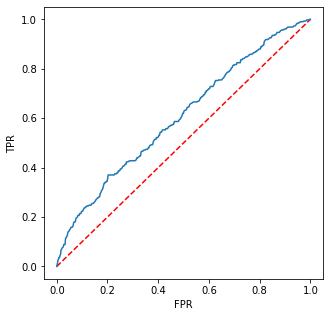

Area under ROC:0.623942074309186


In [113]:
#Extract the summary from the returned LogisticRegressionModel instance trained in the earlier
#example
trainingSummary = model.summary
trainingSummary
print("Accuracy:"+ str(trainingSummary.accuracy))
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print("Area under ROC:"+ str(result_test.areaUnderROC))

In [114]:
trainingSummary.roc.show()

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|0.001034661148473...|0.004807692307692308|
|0.003064188785864...|0.014423076923076924|
|0.004655975168132...| 0.02403846153846154|
|0.006486529507740061|0.028846153846153848|
|0.008595646464244499|0.036057692307692304|
|0.010744558080305623|0.036057692307692304|
|0.012296549803016435|0.040865384615384616|
|0.015042381312427872| 0.05048076923076923|
|0.017151498268932308|  0.0673076923076923|
| 0.01906164192765331| 0.06971153846153846|
|0.021051374905487683| 0.07451923076923077|
| 0.02351864379800231| 0.07692307692307693|
|0.025747144733176807| 0.07932692307692307|
|0.027816467030124557|  0.0889423076923077|
| 0.03032353058219587|  0.0889423076923077|
|0.032751004815153806|  0.0889423076923077|
| 0.03394484460185443| 0.10576923076923077|
| 0.03549683632456525| 0.11538461538461539|
| 0.03840184647220343| 0.1177884

In [115]:
thresh = result_test.predictions.select('Target_final','probability')
thresh.collect()[0]

Row(Target_final=0, probability=DenseVector([0.9807, 0.0193]))

In [129]:
# the probability is a dense vector column. 
# You will have to find a way to access the value of the probability referring to the DELINQUENT class. 
# create a function to access the probability of the positive class form the 'probability' column

from pyspark.sql.functions import udf, when
from pyspark.sql.types import FloatType

element_extrac=udf(lambda v:float(v[1]),FloatType())
# create a list of all the thresholds you want to check the metrics for. 

result_list = []       # to store the values of precision and recall

#NOTE: THE THRESHOLD VALUE SET, IS ACCORDING TO THE DELINQUENT CLASS. SO FOR EG. IF Predicted prob = 0.0193 and threshold=0.01,
# so it means that the prediction = 1 (DELINQUENT) for that particular case.

threshold_list = [0.01,0.02,0.03,0.04,0.05,0.06,0.07]
threshold_list

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]

In [130]:
# Now you have the probabilities, your task is to add a class column. 
# To create this column, compare the probabilities with the threshold and decide the class. 
# You can make a loop which will repeat the same action for different thresholds
# Use the filter and count functions to find the true positives, false positives, false negatives. (inside the loop)
# Using these values, find the precision and recall for different thresholds. (inside the loop)


for i in threshold_list:
    test_pred = thresh.withColumn('label_p',when(element_extrac(thresh["probability"]) >= i, 1).otherwise(0))
    TP = test_pred.filter("Target_final==1 AND label_p==1").count()
    FP = test_pred.filter("Target_final==0 AND label_p==1").count()
    FN = test_pred.filter("Target_final==1 AND label_p==0").count()
    TN = test_pred.filter("Target_final==0 AND label_p==0").count()    
    recall = (TP/(TP+FN))
    presession = ((TP/(TP+FP)))
    list1 = []
    list1.append(i)
    list1.append(presession)
    list1.append(recall)
    list1.append(TP)
    list1.append(TN)
    list1.append(FP)
    list1.append(FN)
    result_list.append(list1)

In [131]:
# Create a panadas datafarme for the list of the output. 

# create a schema for the dataframes 
from pyspark.sql.types import *

schema = StructType([StructField('threshold', FloatType(), True),
                      StructField('precision', FloatType(), True),
                      StructField('recall', FloatType(), True),
                      StructField('TP', IntegerType(), True),
                      StructField('TN', IntegerType(), True),
                      StructField('FP', IntegerType(), True),
                      StructField('FN', IntegerType(), True)])


# create a rdd from the list
rdd = spark.sparkContext.parallelize(result_list)


# create a spark dataframe form rdd
thresh_df = spark.createDataFrame(rdd,schema)

# create pandas dataframe form the spark dataframe 
pandas_df = thresh_df.toPandas()

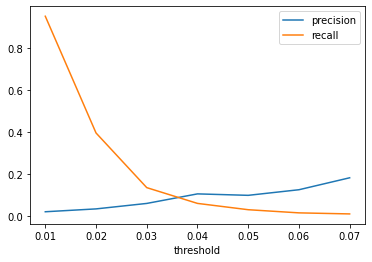

In [132]:
# import matplot lib 
import matplotlib.pyplot as plt

# create the plot
pandas_df.plot.line(x='threshold', y=['precision','recall'])

# display the plot
plt.show()

# MODEL 2 USING THRESHOLD=0.018


In [ ]:
lr2 = LogisticRegression(featuresCol='features', labelCol='Target_final',threshold=0.018)
model2 = lr2.fit(train)
result_test2 = model2.evaluate(test)
result_test2.predictions.select('Target_final','probability','prediction').show(30)
#Extract the summary from the returned LogisticRegressionModel instance trained in the earlier part
trainingSummary2 = model2.summary
trainingSummary2
print("Accuracy:"+ str(trainingSummary2.accuracy))
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(model2.summary.roc.select('FPR').collect(),
         model2.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print("Area under ROC:"+ str(result_test2.areaUnderROC))

+------------+--------------------+----------+
|Target_final|         probability|prediction|
+------------+--------------------+----------+
|           0|[0.98067329393032...|       1.0|
|           0|[0.98590845338311...|       0.0|
|           0|[0.98809628314669...|       0.0|
|           0|[0.98489213383730...|       0.0|
|           0|[0.98676935892977...|       0.0|
|           0|[0.99564847512499...|       0.0|
|           0|[0.98957896818125...|       0.0|
|           0|[0.98303539689787...|       0.0|
|           0|[0.98454977545554...|       0.0|
|           0|[0.96967699183283...|       1.0|
|           0|[0.98323116947532...|       0.0|
|           0|[0.96325779820912...|       1.0|
|           0|[0.97643580538348...|       1.0|
|           0|[0.98650443854230...|       0.0|
|           0|[0.98351218386007...|       0.0|
|           0|[0.97142713532071...|       1.0|
|           0|[0.98389487477870...|       0.0|
|           0|[0.98425908644118...|       0.0|
|           0

In [ ]:
print("RecallByLabel:"+ str(result_test2.recallByLabel))

In [ ]:
#Finding threshold for this model
thresh = result_test2.predictions.select('Target_final','probability')
element_extrac=udf(lambda v:float(v[1]),FloatType())
# create a list of all the thresholds you want to check the metrics for. 

result_list = []       # to store the values of precision and recall
threshold_list = [0.01,0.03,0.05,0.07,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
for i in threshold_list:
    test_pred = thresh.withColumn('label_p',when(element_extrac(thresh["probability"]) >= i, 1).otherwise(0))
    TP = test_pred.filter("Target_final==1 AND label_p==1").count()
    FP = test_pred.filter("Target_final==0 AND label_p==1").count()
    FN = test_pred.filter("Target_final==1 AND label_p==0").count()
    TN = test_pred.filter("Target_final==0 AND label_p==0").count()    
    recall = (TP/(TP+FN))
    presession = ((TP/(TP+FP)))
    list1 = []
    list1.append(i)
    list1.append(presession)
    list1.append(recall)
    list1.append(TP)
    list1.append(TN)
    list1.append(FP)
    list1.append(FN)
    result_list.append(list1)

In [ ]:
# create a rdd from the list
rdd = spark.sparkContext.parallelize(result_list)
# create a spark dataframe form rdd
thresh_df = spark.createDataFrame(rdd,schema)
# create pandas dataframe form the spark dataframe 
pandas_df = thresh_df.toPandas()
# import matplot lib 
import matplotlib.pyplot as plt
# create the plot
pandas_df.plot.line(x='threshold', y=['precision','recall'])
# display the plot
plt.show()

# MODEL 3

In [ ]:
def get_woe_columns(collist):
    anslist=[]
    for col in collist:
        if col[-3:] == 'woe':
            if col not in ('FLAG_OWN_CAR_woe','FLAG_WORK_PHONE_woe','FLAG_PHONE_woe','FLAG_EMAIL_woe'):
                anslist.append(col)
    return anslist

trainCols = get_woe_columns(encoded_df.columns)
#trainCols.extend(['CNT_CHILDREN_FE','AMT_INCOME_TOTAL','DAYS_EMPLOYED_FE','Age_FE','CNT_FAM_MEMBERS_FE'])
trainCols.extend(['CNT_CHILDREN_FE','Age_FE','DAYS_EMPLOYED_FE'])
print('Size of training columns:{}'.format(len(trainCols)))
trainCols

assembler = VectorAssembler(inputCols=trainCols,outputCol='features')
finaldf = assembler.transform(encoded_df)

In [ ]:
# split the data into training and testing data set
# split dataframes between 0s and 1s
zeros = finaldf.filter(finaldf["Target_final"]==0)
ones = finaldf.filter(finaldf["Target_final"]==1)
# split datasets into training and testing
train0, test0 = zeros.randomSplit([0.7,0.3], seed=2018)
train1, test1 = ones.randomSplit([0.7,0.3], seed=2018)
# stack datasets back together
train = train0.union(train1)
test = test0.union(test1)

In [ ]:
lr3 = LogisticRegression(featuresCol='features', labelCol='Target_final',threshold=0.035)
model3 = lr3.fit(train)
result_test3 = model3.evaluate(test)
result_test3.predictions.select('Target_final','probability','prediction').show(30)
#Extract the summary from the returned LogisticRegressionModel instance trained in the earlier
#example
trainingSummary3 = model2.summary
trainingSummary3
print("Accuracy:"+ str(trainingSummary2.accuracy))
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(model2.summary.roc.select('FPR').collect(),
         model2.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print("Area under ROC:"+ str(result_test2.areaUnderROC))

### MODEL PERFORMS BEST WITH A THRESHOLD SET FOR DELINQUENT TARGET (TARGET=1) AS 0.018.
### After using MODEL 2 with 0.018 as the threshold as we can see from the Precion-Recall trade off chart itself that the Recall comes out to be approx. 0.6 with decent Precision and accuracy.

### The reason of such low threshold for delinquent applicants is because there is huge imbalance in the data.

In [ ]:
#The End.